# Preferences

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
print(torch.__version__)

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Image

2.3.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Available GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available, CPU {} ".format(device))

Available GPUs: 1
GPU 0: NVIDIA GeForce GTX 1080


# Data Preprocessing

def my_DataLoader(train_root,test_root,batch_size = 100, val_split_factor = 0.2):

    train_df = pd.read_csv(train_root, header=None)
    test_df = pd.read_csv(test_root, header=None)

    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:, :-1]).float(),
                                                   torch.from_numpy(train_data[:, -1]).long(),)
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_data[:, :-1]).float(),
                                                  torch.from_numpy(test_data[:, -1]).long())

    train_len = train_data.shape[0]
    val_len = int(train_len * val_split_factor)
    train_len -= val_len

    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [3]:
train_pd = pd.read_csv("/home/hanaesori/workspace/jupyter_notebook/Neural_Network/csv/mitbih_train.csv", header=None)
train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_np = train_pd.to_numpy()
train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_np[:, :-1]).float(), torch.from_numpy(train_np[:, -1]).long(),)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)

X_train = train_data.tensors[0]
Y_train = train_data.tensors[1]

print('Data Set(Sample, Features) :', len(train_data), X_train.shape[1]) #=> X shape : (87553, 187)
print('Number of Categories :', len(Y_train.unique()))
print('Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :')
for i in range(len(Y_train.unique())):
    print(f'Label {Y_train.unique()[i].item()} count: {torch.sum(Y_train == Y_train.unique()[i])}')

Data Set(Sample, Features) : 87554 187
Number of Categories : 5
Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :
Label 0 count: 72471
Label 1 count: 2223
Label 2 count: 5788
Label 3 count: 641
Label 4 count: 6431


In [5]:
val_split_factor = 0.2
batch_size = 100

train_len = train_np.shape[0]
val_len = int(train_len * val_split_factor)
train_len -= val_len

train_data, val_data = torch.utils.data.random_split(train_data, [train_len, val_len])
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

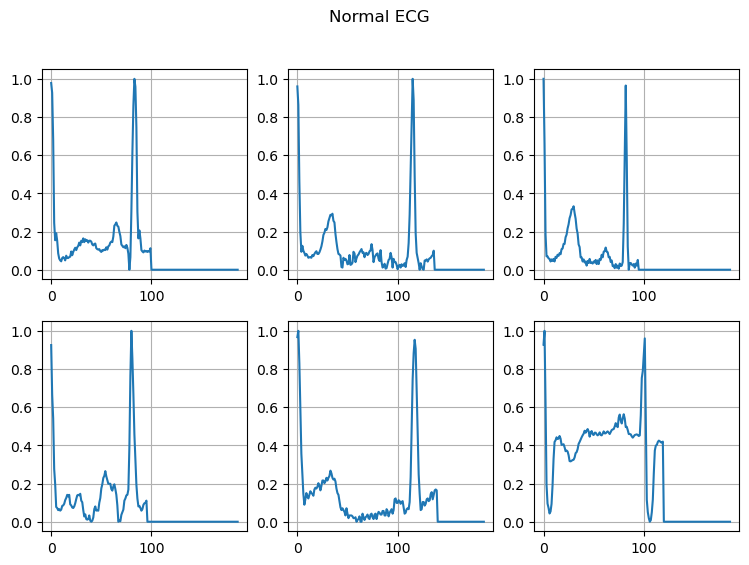

In [6]:
normal_X_train = X_train[Y_train == 0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_X_train[idx])), normal_X_train[idx])
plt.show()

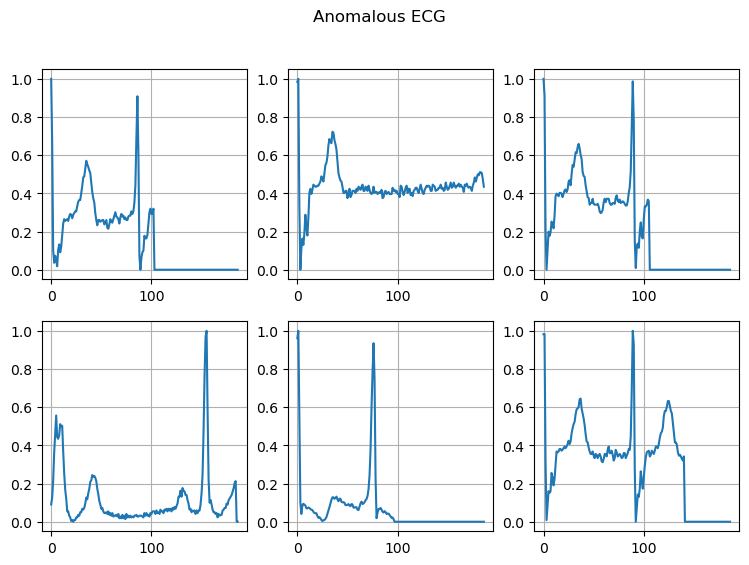

In [7]:
anomalous_X_train = X_train[Y_train!=0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Anomalous ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_X_train[idx])), anomalous_X_train[idx])
plt.show()

# 1D-CNN Modeling

In [8]:
class ConvNet1D(nn.Module):
    def __init__(self, num_of_class):
        super(ConvNet1D, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(2, 2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(92,4),
            nn.LeakyReLU(inplace=True),
            nn.Linear(4, num_of_class),
        )

    def forward(self,x):
        if x.dim() == 2:  # [batch_size, length]
            x = x.unsqueeze(1)
        x = self.layer1(x)
        x = self.layer2(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        #x [b, 2944]
        # print(x.shape)
        x = self.fc(x)

        return x

In [9]:
def evalute(model, loader, crit):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    cur_loss=[]
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
            cur_loss.append(crit(logits, y))
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total, sum(cur_loss)/len(cur_loss)

In [10]:
model = ConvNet1D(len(Y_train.unique())).to(device)
compiled_model = torch.compile(model).cuda

# Model Learning

In [11]:
batch_size = 100
lr = 3e-3
epochs = 70
torch.manual_seed(1234)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [12]:
best_acc, best_epoch = 0, 0
global_step = 0
train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
for epoch in range(epochs):
    correct=0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, (x, y) in enumerate(train_bar):
        # x: [b, 187], y: [b]
        x, y = x.to(device), y.to(device)
        model.train()
        logits = model(x)
        loss = criterion(logits, y)
        preds=logits.argmax(dim=1)
        correct+=torch.eq(preds, y).sum().float().item()
        optimizer.zero_grad()
        loss.backward()
        
        # for param in model.parameters():
        #     print(param.grad)
        optimizer.step()
        
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)
        global_step += 1
    train_loss.append(loss)
    train_acc.append(correct/len(train_loader.dataset))
    print('Train Acc: {}'.format(correct/len(train_loader.dataset)))
    if epoch % 1 == 0:  # You can change the validation frequency as you wish
        val_acc_epo, val_loss_epo = evalute(model, val_loader, criterion)
        val_acc.append(val_acc_epo)
        val_loss.append(val_loss_epo)
        print('val_acc = ',val_acc_epo)
        if val_acc_epo > best_acc:
            best_epoch = epoch
            best_acc = val_acc_epo
            #torch.save(model, 'proposed.pt')
            torch.save(model.state_dict(), 'proposed.mdl')
            #torch.save(model.state_dict(), 'proposed_weights.pt')
print('best acc:', best_acc, 'best epoch:', best_epoch)
model.load_state_dict(torch.load('proposed.mdl'))
print('loaded from ckpt!')

  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.5503118075701853


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8285551113649343


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8277291728533248


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8285551113649343


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8277291728533248


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8285551113649343


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8277291728533248


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8285551113649343


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8277177513306074


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8286122215876642


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8415492153413893


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8572244431753284


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8777554423555749


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8845802398629354


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8848824725312379


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8876641918903484


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8883546154373301


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8920616790405482


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.8951732644996231


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.8993717875499715


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9006099093131096


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9005139920045688


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9020947072663728


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9055396916047973


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9038536217648537


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.906510565391205


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9054754779907257


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9074243289548829


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9076684103524681


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9090234151913192


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9100897731685589


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9131924614505996


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.913756081960847


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9174757281553398


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9178564086163967


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9220445459737293


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9206661032048793


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.922215876641919


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9220709504991206


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9253569388920617


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9238869726111886


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.925242718446602


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9254974073143432


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.926956025128498


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9283071019028257


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9319246145059966


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9303972405601115


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.933066818960594


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9317678232862006


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9332952598515134


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9335952669209859


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9338663620788121


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.935776777760011


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9385494003426613


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9376270644402311


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.940434037692747


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9403225438015396


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9428326670474015


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9411791580053452


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.942604226156482


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9414304315051283


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9375214163335237


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9420814583000205


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9396916047972587


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9420700367773032


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9420902341519132


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9438061082303493


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9439748715019989


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9430979738218699


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9438035408338092


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9434977271169792


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9467732724157624


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9440802247755671


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9461450599657338


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9443429197980675


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9462021701884638


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9449825250702424


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9450599657338664


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9450396326838294


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9467161621930326


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9451881124791557


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9472301541976014


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.945587865774265


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9452884066247859


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9457020810014392


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9479154768703598


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9465472736825273


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9479154768703598


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9468099687050278


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9483152484294689


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.946592959773397


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9475728155339805


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9470498206820933


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9476870359794404


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9471868789547022


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9487721302113078


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9472325650455719


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9478012564249001


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9475066815907897


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9478583666476299


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9477465335678553


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9494003426613363


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9471983004774196


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.949971444888635


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9476894259542682


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9461450599657338


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9477236905224204


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9492290119931468


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9484546679763346


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.948715019988578


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9480320716357905


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9492861222158766


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9483632957945953


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9495145631067962


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9483061881810083


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9500856653340948


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9484204034081823


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9496287835522559


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9484546679763346


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9490005711022274


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9486374123398131


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9502569960022844


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9483061881810083


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.951284980011422


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9490714302030747


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9492861222158766


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9491742239075314


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.948715019988578


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9490257441122051


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9498572244431753


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9492884391347054


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9508280982295831


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9485117755899216


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9507138777841233


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.949219909998401


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.950428326670474


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9490029010667702


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.951741861793261


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9495282911117711


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.950428326670474
best acc: 0.951741861793261 best epoch: 68
loaded from ckpt!


# Model Inference

In [13]:
test_pd = pd.read_csv("/home/hanaesori/workspace/jupyter_notebook/Neural_Network/csv/mitbih_test.csv", header=None)
test_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
test_np = test_pd.to_numpy()
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_np[:, :-1]).float(), torch.from_numpy(test_np[:, -1]).long(),)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

X_test = test_data.tensors[0]
Y_test = test_data.tensors[1]

print('Data Set(Sample, Features) :', len(test_data), X_test.shape[1]) #=> X shape : (87553, 187)
print('Number of Categories :', len(Y_test.unique()))
print('Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :')
for i in range(len(Y_test.unique())):
    print(f'Label {Y_test.unique()[i].item()} count: {torch.sum(Y_test == Y_test.unique()[i])}')

Data Set(Sample, Features) : 21892 187
Number of Categories : 5
Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :
Label 0 count: 18118
Label 1 count: 556
Label 2 count: 1448
Label 3 count: 162
Label 4 count: 1608


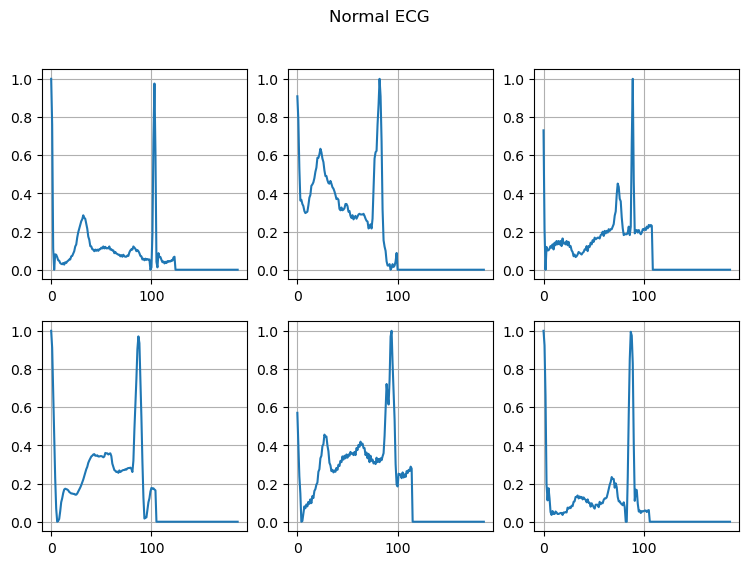

In [15]:
normal_X_test = X_test[Y_test == 0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_X_test[idx])), normal_X_test[idx])
plt.show()

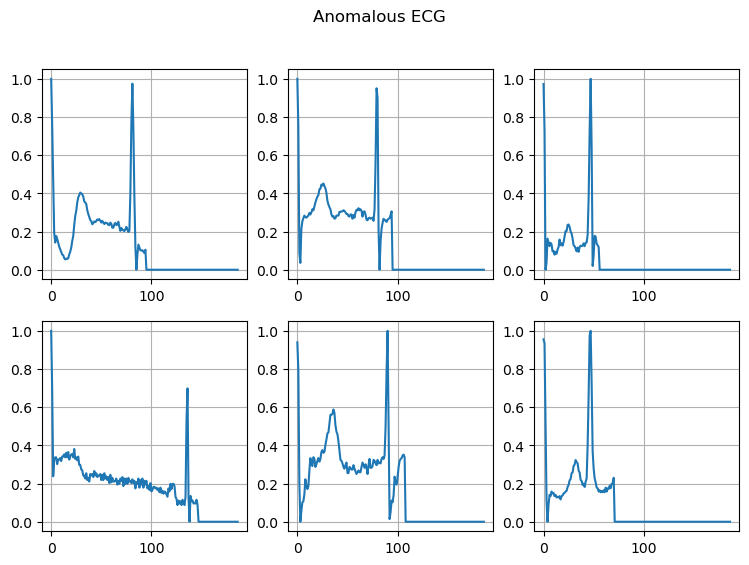

In [16]:
anomalous_X_test = X_test[Y_test!=0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Anomalous ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_X_test[idx])), anomalous_X_test[idx])
plt.show()

test_acc = evalute(model, test_loader, criterion)
print('test acc:', test_acc)

In [17]:
batch_size = 1000
iteration = 10
criterion = nn.CrossEntropyLoss()

In [18]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)
timings=np.zeros((iteration,1))

In [19]:
best_acc, best_epoch = 0, 0
test_acc=[]
test_loss=[]
with torch.no_grad(): # Gradient 연산 비활성화
    for _ in range(iteration):
        starter.record()
        
        correct = 0
        total = 0
    
        test_bar = tqdm(test_loader, file=sys.stdout)
        for step, (x, y) in enumerate(test_bar):
            x, y = x.to(device), y.to(device)
            logits_test = model(x)
            loss = criterion(logits_test, y)
            preds = logits_test.argmax(dim=1)
            correct += torch.eq(preds, y).sum().item()
            total += y.size(0)
            
            test_bar.desc = "test iteration[{}/{}] loss:{:.3f}".format(_ + 1,
                                                                     iteration,
                                                                     loss)
        
        accuracy = correct / total
        test_acc.append(accuracy)  # append를 사용하여 정확도를 리스트에 추가
        
        ender.record()
        torch.cuda.synchronize() # Gpu 연산이 완료될 때까지 대기

average_acc = sum(test_acc) / iteration  # sum 함수와 iteration으로 나누어 평균 계산
print(f"Average Test Accuracy: {average_acc * 100:.2f}%")

infer_time = starter.elapsed_time(ender)
print("Elapsed time: {} s".format(infer_time * 1e-3)) # milliseconds to second

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Average Test Accuracy: 94.86%
Elapsed time: 0.12103395080566406 s


# Record

In [20]:
results = [train_acc, train_loss, val_acc, val_loss]
for i in range(len(results[1])):  # Assuming results[1] refers to train_loss
    results[1][i] = results[1][i].item()
for i in range(len(results[3])):
    results[3][i]=results[3][i].item()

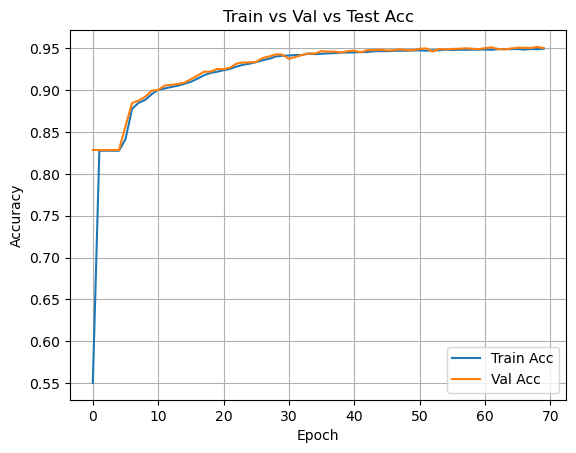

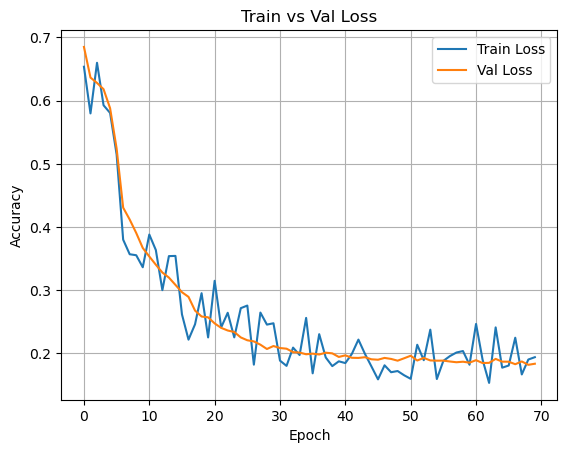

In [21]:
plt.plot(results[0])
plt.plot(results[2])
plt.legend(['Train Acc', 'Val Acc', 'Test Acc'])
plt.title('Train vs Val vs Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
plt.plot(results[1])
plt.plot(results[3])
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [22]:
print(model)

ConvNet1D(
  (layer1): Sequential(
    (0): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=92, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=4, out_features=5, bias=True)
  )
)


In [23]:
summary(model, input_size=(1, 187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 2, 187]               8
         MaxPool1d-2                [-1, 2, 93]               0
            Conv1d-3                [-1, 2, 93]              14
         MaxPool1d-4                [-1, 2, 46]               0
            Linear-5                    [-1, 4]             372
         LeakyReLU-6                    [-1, 4]               0
            Linear-7                    [-1, 5]              25
Total params: 419
Trainable params: 419
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [24]:
print(os.system('dot -V'))

0


dot - graphviz version 2.50.0 (0)


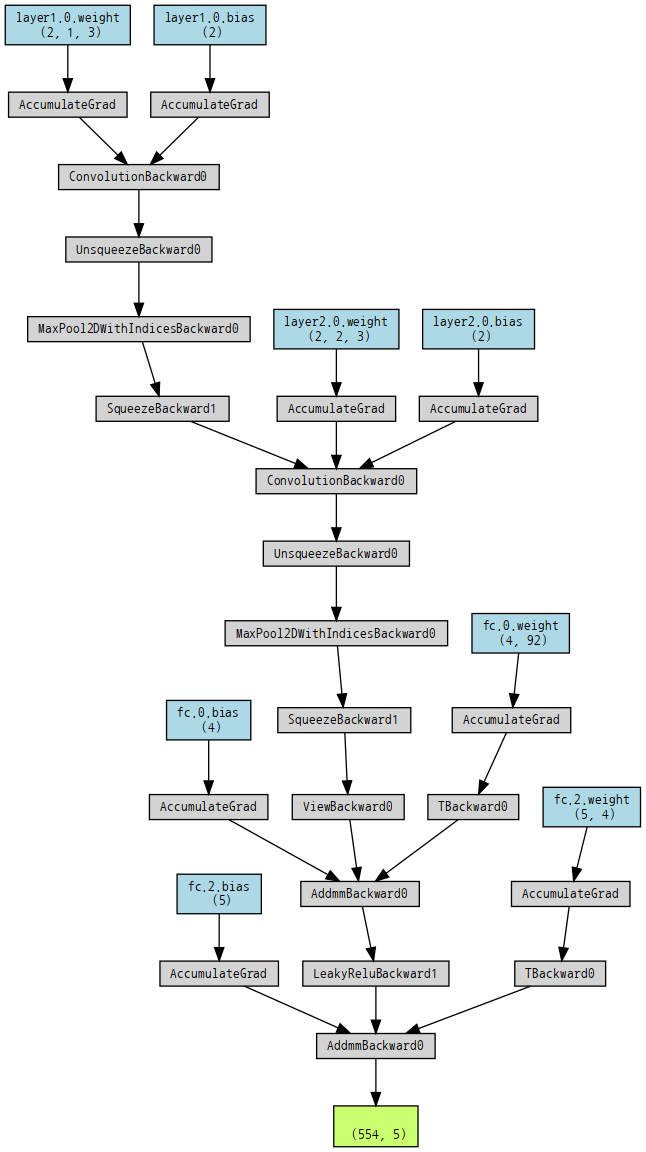

In [25]:
make_dot(logits, params=dict(list(model.named_parameters()))).render("proposed", format="png")
Image(filename='proposed.png')

In [26]:
for name, child in model.named_children():
    for param in child.parameters():
        print(name, param)

layer1 Parameter containing:
tensor([[[ 1.0753, -0.3332, -0.7774]],

        [[-2.5551, -2.4179, -0.3980]]], device='cuda:0', requires_grad=True)
layer1 Parameter containing:
tensor([0.3501, 0.6372], device='cuda:0', requires_grad=True)
layer2 Parameter containing:
tensor([[[ 0.5040,  0.3427, -0.0440],
         [ 0.3486,  1.6782,  0.9274]],

        [[-0.3668,  0.6762, -0.5321],
         [-1.3935, -0.4320, -0.8254]]], device='cuda:0', requires_grad=True)
layer2 Parameter containing:
tensor([ 0.4541, -0.5494], device='cuda:0', requires_grad=True)
fc Parameter containing:
tensor([[-3.7614e-01, -4.8606e-02, -2.0652e-01, -6.8906e-01, -8.8526e-02,
         -2.0782e-01, -3.2565e-01, -5.2229e-01,  8.2257e-01,  2.3762e-01,
         -2.3038e-01,  5.6319e-02, -2.2583e-01,  1.0737e-01, -1.1015e-01,
          2.9143e-01,  3.8856e-01,  6.3242e-01,  6.5770e-01,  4.9983e-01,
          5.6205e-01,  4.6746e-01,  3.3188e-01,  1.8895e-01,  2.1099e-01,
          5.4926e-01,  5.3689e-01,  5.0155e-01,  3.41

In [27]:
weights_l1 = model.layer1.param
print(weights_l1)
weights_l1 = weights_l1.detach().numpy()
pd.DataFrame(weights_l1).to_csv('weights.csv')

AttributeError: 'Sequential' object has no attribute 'param'